# Functions

> Basic classes to work with mathematical functions

In [ ]:
#|default_exp func

In [ ]:
#|hide
from nbdev.test import *

In [ ]:
#|export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.all import *

In [ ]:
#|export
class class_decorator:
    '''Method decorator that can access its class. \n
    Has 2 arguments, method itself and action with arguments `(self,owner,name)`'''
    def __init__(self, fn, act): store_attr()
    def __set_name__(self, owner, name):
        self.act(self, owner, name)
        setattr(owner, name, self.fn)

In [ ]:
#|export
def implements(np_func):
    "Register an __array_function__ implementation"
    def act(dec,owner,name): owner.HANDLED_FUNCTIONS[np_func]=dec.fn
    def decorator(func): return class_decorator(func,act)
    return decorator

class NumpyHelper(np.lib.mixins.NDArrayOperatorsMixin):
    HANDLED_FUNCTIONS={}
    def __len__(self): return len(np.array(self))
    def __iter__(self): return iter(np.array(self))

    @property
    def dtype(self):
        return np.array(self).dtype

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
            if method!='__call__': return NotImplemented
            if ufunc in self.HANDLED_FUNCTIONS: 
                return self.HANDLED_FUNCTIONS[ufunc](*inputs,**kwargs)
            # try default implementation
            inputs = (np.array(i) if isinstance(i,NumpyHelper) else i for i in inputs)
            return self.from_array(ufunc(*inputs,**kwargs))
    
    @classmethod
    def from_array(cls, array): 
        '''Should return instance of a class constructed from pure numpy array'''
        raise NotImplementedError
    
    def __array__(self, dtype=None, copy=None): raise NotImplementedError


In [ ]:
# TODO
# 3. Implement function class, you can add functions, subtract, multiply negate, show them, concatenate their domains(which is like addition)
# Also special methods like horizontal shift and scale(where you don't add scalar to y, but to x) 
# 4. Create waves that are just aliases for functions of sine, Pulse is a product of gaussian function and wave
# 5. Create sound class, that has discretizatoin rate and time, classes that inherit from it can be converted to wav
# 6. so then we can inherit from sound and from wave and build some sequences of pulses of different sizes and amplitudes

In [ ]:
#|export
class Function(NumpyHelper):
    HANDLED_FUNCTIONS={} #TODO ask in python server how to not write this
    def __init__(self, func, x_min=-5, x_max=5, num=1000):
        store_attr('x_min,x_max,num')
        self.x = np.linspace(x_min, x_max, num)
        self.y = func(self.x)
        if not isinstance(self.y, np.ndarray): self.y *= np.ones_like(self.x)
    
    @staticmethod
    def inplace(func):
        def _f(self, *args, **kwargs):
            obj = Function(noop, self.x_min, self.x_max, self.num)
            func(self,obj,*args,**kwargs)
            return obj
        return _f
    
    @implements(np.add)
    @inplace
    def _add(self, obj, other): obj.y = self.y + (other.y if isinstance(other, Function) else other)
    
    @implements(np.negative)
    @inplace
    def _neg(self, obj): obj.y = -self.y
    
    @implements(np.subtract)
    def _sub(self, other): return self + (-other)
    
    @implements(np.multiply)
    @inplace
    def _mult(self, obj, other): obj.y = self.y * (other.y if isinstance(other, Function) else other)
    
    @implements(np.equal)
    def _eq(self, other):
        if isinstance(other, Function):
            return np.all(self.x==other.x) and np.all(self.y==other.y)

    @inplace
    def inverse(self, obj): obj.x, obj.y = self.y, self.x
    
    @inplace
    def shift(self, obj, x): obj.x +=x
    

    def show(self, ax=None):
        ax = ifnone(ax, plt.subplots()[1])
        ax.plot(self.x,self.y)
        
    def __repr__(self):
        self.show()
        return ''

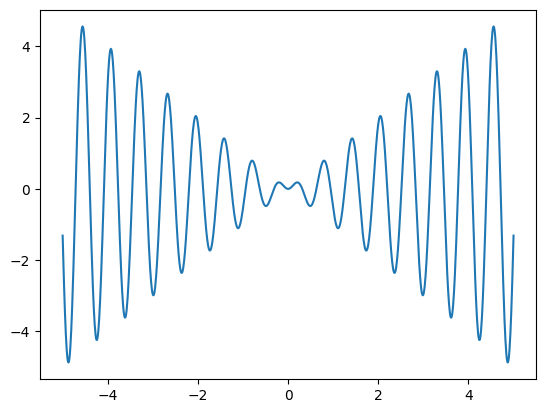

In [ ]:
Function(lambda x: x*np.sin(10*x))

In [ ]:
test_eq(Function(lambda x:x).shift(10)*10, Function(lambda x:10*(x+10)))

True